In [1]:
import cupy as cp
import numpy as np
from tqdm.auto import trange

In [ ]:
sys.path.append(str(pathlib.Path('../').resolve()))

In [26]:
from lib.utils.nn import accuracy, plot_history, l2_loss
from lib.utils.enums import Initialization, NonLinearity, OptimizerName
from lib.utils.train import train_step_local, val_step
from lib.utils.data import Dataset, shuffle_dataset, load_integer_dataset
from lib.utils.misc import to_cpu
from lib.experiments import build_augmentation_pipeline

# Experiment config

In [27]:
architecture = [
    ('Conv2d', 64, 11, 1, 2),
    ('MaxPool2d', 2, 2),
    ('Conv2d', 192, 5, 1, 2),
    ('MaxPool2d', 2, 2),
    ('Conv2d', 384, 3, 1, 1),
    ('Conv2d', 256, 3, 1, 1),
    ('Conv2d', 256, 3, 1, 1),
    ('MaxPool2d', 2, 2)
]
num_fc_layers = 2
num_fc_hidden = [1024]

In [28]:
dataset_config = dict(
    dataset=Dataset.CIFAR10.name,
    subsample_ratio=0.5,
    ohe_values=(0, 32),
    add_padding=False,
    normalize=True,
    data_augmentation=True,
)

In [29]:
network_config = dict(
    num_fc_layers=num_fc_layers,
    num_fc_hidden=num_fc_hidden,
    non_linearity=NonLinearity.NITRO_LEAKY_RELU.name,
    init=Initialization.UNIFORM_KAIMING_LEAKY_RELU.name,
    dtype='int32',
    device='cuda',
    local_loss='pred',
    pred_decoder_dim=4096,
    fe_dropout_rate=0.0,
    fc_dropout_rate=0.25,
    seed=42,
    bias=False,
    debug=False,
)

In [30]:
training_config = dict(
    batch_size=64,
    num_epochs=35,
    lr_inv=512,
    lr_amp_factor=None,
    fwd_decay_inv=15_000,
    subnet_decay_inv=1_000,
    optimizer=OptimizerName.INTEGER_SGD.name,
)

In [31]:
config = dataset_config | network_config | training_config

In [32]:
# Setup reproducibility
np.random.seed(config["seed"])
cp.random.seed(config["seed"])

# Data

Files already downloaded and verified
Files already downloaded and verified
Subsampling applied: training on 20000 samples
Data normalized. New statistics:
-  Min: [-123 -123 -105]
-  Max: [126 127 127]
- Mean: [0 0 0]
-  Std: [61 61 61]

Moved data to device: <CUDA Device 0>
Train set:  (20000, 3, 32, 32), (20000, 10)
Val set:    (10000, 3, 32, 32), (10000, 10)
Test set:   (10000, 3, 32, 32), (10000, 10)
Data types: (int8, int8)


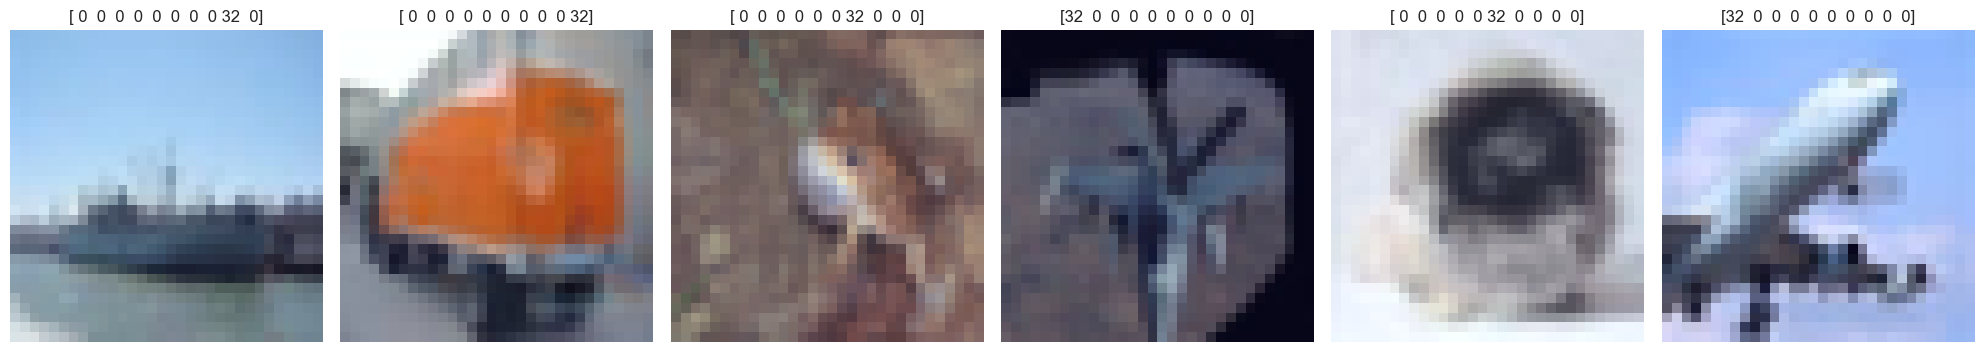

In [33]:
X_train, X_val, X_test, y_train, y_val, y_test = load_integer_dataset(config, add_padding=False, ohe_values=(0, 32))

In [34]:
# Configure data augmentation
augmentation_pipeline = build_augmentation_pipeline(config)
print(augmentation_pipeline)

AugmentationPipeline([
    RandomCrop(size=32, padding=4, probability=0.5)
    RandomHorizontalFlip(probability=0.5)
])


# Network

In [35]:
from lib.models.local_loss_models import IntegerLocalLossCNN

In [36]:
model = IntegerLocalLossCNN(
    fe_architecture=architecture,
    input_channels=X_train.shape[1],
    image_size=X_train.shape[2],
    num_fc_layers=config['num_fc_layers'],
    num_hidden_fc=config['num_fc_hidden'],
    num_classes=y_train.shape[1],
    local_loss=config['local_loss'],
    fe_dropout_rate=config['fe_dropout_rate'],
    fc_dropout_rate=config['fc_dropout_rate'],
    pred_decoder_dim=config['pred_decoder_dim'],
    fwd_decay_inv=config['fwd_decay_inv'],
    subnet_decay_inv=config['subnet_decay_inv'],
    device=config['device'],
    non_linearity=NonLinearity[config['non_linearity']],
    init=Initialization[config['init']],
    optimizer=OptimizerName[config['optimizer']],
    dtype=config['dtype'],
    bias=config['bias'],
    debug=config['debug'],
    lr_amp_factor=config['lr_amp_factor']
)
print(model.extra_repr(1))

IntegerLocalLossCNN(
	(0): Sequential(
			(0): LocalConv2dBlock(
			(0): IntegerConv2d(in_channels=3, out_channels=64, bias=False, decay_rate_inv=15000)
			(1): ConstantScaling(fwd_factor=92928, bwd_factor=1)
			(2): PocketZeroLeakyReLU(negative_slope_inv=4)
			(pred_loss_net): Sequential(
			(0): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=(2, 2))
			(1): Flatten()
			(2): IntegerLinear(in_features=3136, out_features=10, bias=False, decay_rate_inv=1000)
			(3): ConstantScaling(fwd_factor=802816, bwd_factor=1)
		)
	)
			(1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
			(2): LocalConv2dBlock(
			(0): IntegerConv2d(in_channels=64, out_channels=192, bias=False, decay_rate_inv=15000)
			(1): ConstantScaling(fwd_factor=409600, bwd_factor=1)
			(2): PocketZeroLeakyReLU(negative_slope_inv=4)
			(pred_loss_net): Sequential(
			(0): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=(2, 2))
			(1): Flatten()
			(2): IntegerLinear(in_features=3072, out_features=10, 

In [37]:
model.print_layers_parameters()

Layer: conv_encoder_00
- Weights:
[[[[  8  -9 -16 ...   5  13  13]
   [ 14   1  -2 ... -13  -5   7]
   [ -5  -3 -14 ...  -5  13  11]
   ...
   [  3 -12   0 ...   9 -10  10]
   [ -9   4 -16 ...  -6   1 -11]
   [ -2 -13   4 ...   8  -2  10]]

  [[-10  -1 -11 ...  -4   7   1]
   [  7 -13   6 ...   0   2  16]
   [ -5 -11 -12 ... -14   0  -9]
   ...
   [  3   7  16 ... -11  -8  -5]
   [ -1   1   0 ... -14 -13  -9]
   [ -8  13  -1 ...   7   7  -5]]

  [[  9  14  -7 ...  -8 -11  -5]
   [ 11 -11  14 ...   0  -9 -13]
   [-13   6   7 ...  -1   3  16]
   ...
   [ -8  -2   7 ...  -2 -14 -13]
   [-12  -8 -16 ... -10  -4  -7]
   [ 16 -13 -15 ... -10   9  -1]]]


 [[[  2  -4 -16 ...  -6 -12 -12]
   [ -7   9  -3 ...  16  -8  15]
   [  0  -6  -3 ...  -2   5 -11]
   ...
   [  2   2  -9 ...  15 -15 -14]
   [ 15  -8  -3 ...   4 -14  12]
   [-13   3  10 ...   7 -16 -16]]

  [[ -6  13   9 ...  -6 -15 -11]
   [  3  -7  10 ...   4   6  -5]
   [ 14   9  -2 ...   4 -12 -15]
   ...
   [-14   6 -15 ...  -1   5 -1

# Training

In [38]:
from lib.optim.lr_schedulers import ConstantLR
from lib.utils.nn import EarlyStopping, ReduceLROnPlateau

In [39]:
lr_scheduler = ConstantLR(config['lr_inv'])
early_stopping = EarlyStopping(min_delta=0.01, patience=25, from_epoch=10)
reduce_lr_plateau = ReduceLROnPlateau(factor=2, min_delta=0.01, patience=15, from_epoch=10)

In [ ]:
n_train_batches = len(X_train) // config['batch_size']
n_val_batches = len(X_val) // config['batch_size']
last_epoch = 0

xp = cp.get_array_module(X_train)
loss_history = xp.empty(config['num_epochs'])
acc_history = xp.empty(config['num_epochs'])
val_loss_history = xp.empty(config['num_epochs'])
val_acc_history = xp.empty(config['num_epochs'])

for epoch in trange(config['num_epochs']):
    # Train and validation loops
    lr_scheduler.step()
    X_train, y_train = shuffle_dataset(X_train, y_train)
    
    loss_history[epoch], acc_history[epoch], local_losses, local_accuracies = train_step_local(
        model=model,
        X_train=X_train,
        y_train=y_train,
        batch_size=config['batch_size'],
        n_train_batches=n_train_batches,
        augmentation_pipeline=augmentation_pipeline,
        lr_inv=lr_scheduler.get_lr()
    )
    
    val_loss_history[epoch], val_acc_history[epoch] = val_step(
        model=model, 
        X_val=X_val, 
        y_val=y_val, 
        batch_size=config['batch_size'], 
        n_val_batches=n_val_batches
    )
    
    last_epoch = epoch

    if epoch % 3 == 0:
        print(f"Epoch {epoch}:")
        for i, (local_loss, local_acc) in enumerate(zip(local_losses, local_accuracies)):
            print(f"- Local accuracy {i}: {local_acc:.2%}")
        print(f"- Output accuracy: {acc_history[epoch]:.2%}")
        print(f"- Output val accuracy: {val_acc_history[epoch]:.2%}")
        print("\n")

    # Early stopping
        if early_stopping.early_stop(float(val_acc_history[epoch])):
            print(f"{'-' * 64}\nEarly stopping at epoch {epoch + 1}\n{'-' * 64}")
            break

    # ReduceLROnPlateau
    if reduce_lr_plateau.reduce_lr(float(val_acc_history[epoch])):
        lr_scheduler.set_lr(lr_scheduler.get_lr() * reduce_lr_plateau.factor)
        print(f"{'-' * 64}\nReducing learning rate on plateau at epoch {epoch + 1}\n{'-' * 64}")
    
print(f'Final train loss: {loss_history[last_epoch]:.5f}')
print(f'Final train accuracy: {acc_history[last_epoch]:.2%}')
print(f'Final validation loss: {val_loss_history[last_epoch]:.5f}')
print(f'Final validation accuracy: {val_acc_history[last_epoch]:.2%}')

  3%|▎         | 1/35 [00:30<17:13, 30.40s/it]

Epoch 0:
- Local accuracy 0: 28.59%
- Local accuracy 1: 9.78%
- Local accuracy 2: 9.88%
- Local accuracy 3: 9.85%
- Local accuracy 4: 10.13%
- Local accuracy 5: 15.26%
- Output accuracy: 9.99%
- Output val accuracy: 10.20%




 11%|█▏        | 4/35 [01:54<14:42, 28.48s/it]

Epoch 3:
- Local accuracy 0: 47.35%
- Local accuracy 1: 38.01%
- Local accuracy 2: 35.90%
- Local accuracy 3: 33.61%
- Local accuracy 4: 31.86%
- Local accuracy 5: 19.12%
- Output accuracy: 12.39%
- Output val accuracy: 17.08%




 20%|██        | 7/35 [03:22<13:33, 29.07s/it]

Epoch 6:
- Local accuracy 0: 52.65%
- Local accuracy 1: 47.44%
- Local accuracy 2: 45.78%
- Local accuracy 3: 43.35%
- Local accuracy 4: 41.70%
- Local accuracy 5: 38.10%
- Output accuracy: 32.98%
- Output val accuracy: 38.40%




 29%|██▊       | 10/35 [04:52<12:22, 29.69s/it]

Epoch 9:
- Local accuracy 0: 53.98%
- Local accuracy 1: 52.64%
- Local accuracy 2: 50.63%
- Local accuracy 3: 49.02%
- Local accuracy 4: 47.43%
- Local accuracy 5: 47.57%
- Output accuracy: 45.07%
- Output val accuracy: 44.74%




 37%|███▋      | 13/35 [06:20<10:47, 29.44s/it]

Epoch 12:
- Local accuracy 0: 55.38%
- Local accuracy 1: 56.00%
- Local accuracy 2: 55.06%
- Local accuracy 3: 53.32%
- Local accuracy 4: 51.67%
- Local accuracy 5: 52.13%
- Output accuracy: 50.03%
- Output val accuracy: 53.16%




 46%|████▌     | 16/35 [07:46<09:08, 28.88s/it]

Epoch 15:
- Local accuracy 0: 56.19%
- Local accuracy 1: 58.17%
- Local accuracy 2: 57.62%
- Local accuracy 3: 55.71%
- Local accuracy 4: 54.58%
- Local accuracy 5: 54.94%
- Output accuracy: 53.63%
- Output val accuracy: 53.41%




In [ ]:
y_subnets = model.subnetworks_predict(X_test)
for i, y_subnet in enumerate(y_subnets):
    subnet_acc = accuracy(y_test, y_subnet)
    print(f'Local Val Accuracy {i}: {subnet_acc:.2%}')

In [ ]:
loss_history, val_loss_history  = loss_history[:last_epoch+1], val_loss_history[:last_epoch+1]
acc_history, val_acc_history = acc_history[:last_epoch+1], val_acc_history[:last_epoch+1]

if config['device'] == 'cuda':
    # Move training statistics to the CPU
    loss_history, val_loss_history = to_cpu(loss_history), to_cpu(val_loss_history)
    acc_history, val_acc_history = to_cpu(acc_history), to_cpu(val_acc_history)

In [ ]:
plot_history(loss_history, val_loss_history, acc_history, val_acc_history, log_scale=True)

In [ ]:
y_pred = model.predict(X_test, progress_bar=False)
test_loss = l2_loss(y_test, y_pred)
test_acc = accuracy(y_test, y_pred)
print(f'Test accuracy: {test_acc:.2%}')